# Amazon Fine Food Reviews Analysis
Data source : https://www.kaggle.com/snap/amazon-fine-food-reviews

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 <br>
Number of users: 256,059 <br>
Number of products: 74,258 <br>
Timespan: Oct 1999 - Oct 2012 <br>
Number of Attributes/Columns in data: 10  <br>

# Objective
Classfication of positive and negative reviews used ML algo
Given a review, determine wheter the review is positive (rating 4 or 5) or negative

Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

__[Q]__ How to determine if a review is positive or negative?

__[Ans]__ We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
#for large and multi-dim arrays
import numpy as np
#for data manipulation and analysis
import pandas as pd
#Natural language processing
import nltk
#Stopwords corpus
from nltk.corpus import stopwords
#Stemmer
from nltk.stem import PorterStemmer
#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
#TF_IDF
from sklearn.feature_extraction.text import TfidfTransformer
# Word2Vec
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import seaborn as sns

In [2]:
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


If we see the Score column, it has values 1,2,3,4. Considering 1,2 as Negative and 4,5 as positive, the Neutral is 3, we will delete the rows that neutral

HelfulnessNumerator says about number of people found review usefull and HelpfulnessDenomitor usefull review count + not so usefull.

In [3]:
# Remove neutral review
df_1 = df[df['Score'] != 3]

Convert the score to categorical, Positive and Negative

In [4]:
def partition(score):
    if score > 3:
        return 'Positive'
    return 'Negative'

score = df_1['Score']
convert = score.map(partition)
df_1['Score'] = convert

In [5]:
df_1.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


### EXPLORATPRY DATA ANALYSIS
that will help us to undrestand our data

#### Preprocessig
1st: We can't work with the text data in ML, so we need to convert them in to numerical vectors

2nd: Text data needs to cleaned and encoded into numerical values before given then, this cleaning and encoding is called as Text Preporcessing

Understanding the data- what's data is all about, what should be considered for cleaning for data (punctuations, stopwords, ect...)

Some Encoding Techniques:

 - Bag of words
 - Binary bag of words
 - Bigram, Ngram
 - TF, IDF
 - Word2Vec
 - TF-IDF Word2Vec

Sorting data for time based splitting for model train and test dataset


In [6]:
import datetime

df_1["Time"] = df_1["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

sortedData = df_1.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)

    Reviews may have duplicate entriees. Hence it is necessry to remove diplicates in order to get unbiased results

In [8]:
# drop duplicates
final = sortedData.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep="first", inplace=False)

       Helfluness numerator should always be less thank Denominator
           - Helpfulness Numerator : number of people found that review are useful
           - Hulpfulness Denominator : is about useful review count + not so useful

In [9]:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]

#### As data is huge, we are limiting our data due to computation limition, we will try to pick data in a way so that it does't make data imbalance problem

In [10]:
# As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'Positive']
finalp = finalp.sample(frac=0.035,random_state=1) #0.055

finaln = final[final.Score == 'Negative']
finaln = finaln.sample(frac=0.15,random_state=1) #0.25

final = pd.concat([finalp,finaln],axis=0)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


print(final.shape)

(19313, 10)


Converting all words to lowercase and removing punctuations and html tags if any

__Stemming__ : Converting the words into their base word or stem word (Ex- tastfully, tasty these words converted to stem word called 'tasti'). This reduces the vector dimension

__Stopwords__ : are unnecessary words

In [11]:
# all english stopwords
#nltk.download('stopwords')
stop = set(stopwords.words('english'))
print(stop)

{'aren', 'being', 'own', 'about', "she's", 'i', 'that', 'we', 'both', 'same', "you'd", 'he', 'after', 'm', 'these', "don't", 'from', 'am', 'each', 'but', 'can', 'should', 'now', 'ain', "weren't", 'shouldn', "you're", 'did', 'why', 'o', 'd', 'mightn', 'himself', 'my', 'weren', 'those', 'don', 'so', 'been', "you've", "shouldn't", 'above', 'her', 'a', 'in', 'below', 'too', 'yourselves', 'if', 'will', 'myself', 'until', 't', 're', "that'll", 'all', 'll', 'before', "aren't", 'hers', 'over', 'ourselves', 'ours', 'by', 'haven', "hasn't", 'yourself', 'once', 'an', 'do', 's', 'up', 'hasn', 'has', 'further', 'what', 'such', 'shan', "wouldn't", 'and', 'most', 'our', "shan't", 'with', 'other', 'who', 'no', 'ma', 've', 'as', 'does', 'the', 'isn', 'him', 'me', 'than', 'on', 'when', 'only', 'then', "wasn't", 'wouldn', 'doing', 'more', 'mustn', 'against', 'whom', 'itself', 'wasn', "you'll", 'just', 'they', 'yours', 'very', 'nor', "should've", 'here', 'are', 'it', 'is', "mightn't", 'few', 'again', 'you

In [12]:
import re
import string 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) # set of stopwords
sno = nltk.stem.SnowballStemmer('english') # initialisig the snowball stemmer

remove html-tags

In [13]:
def delHtml(sentence):
    cleaner = re.compile('<.*?>')
    cleanedtext = re.sub(cleaner,' ', sentence)
    return cleanedtext

remove punctuation or special characters

In [15]:
def delpun_sp(sentence):
    cleaner_punc = re.compile('[?|!|\'|"|#]')
    cleaned = re.sub(cleaner_punc,'', sentence)
    cleaner_spe = re.compile('[.|,|)|(|\|/]')
    cleand = re.sub(cleaner_spe, ' ', cleaned)
    
    return cleaned

In [16]:
i = 0
str1 = 1
final_X =[]
all_positive_words = []
all_negative_words = []
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=delHtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in delpun_sp(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_X.append(str1)
    i+=1

### BAG OF WORD (BOW)

In BoW we construct a dictionary that contains set of all unique words from our test review dataset. The frequency of the word is counted here, if there are d unique words in our dictionary then for every sentence or review the vector will be of lenght d and count of word from review is stored at its particular location in vector. The vector will be highly sparce in such case.

Ex: pasta is tasty and pasta is good [0].....[1]....[1]....[2]....[2]....[1].... <== its vector representation [a]...[and]..[is]..[pasta]...[tasty] <== This is dictonary

Using sckit-learn's __CountVectorize__ we can get the BoW and check out all the parameters it consists of, one of them is __max_features=5000__ it tells about to consider only top 5000 most frequently repeated words to place in a dictionary. so our dictionary lenght or vector lenght will be only 5000

#### BINARY BAG OF WORDS
In binary BoW, we dont count the frequency of word, we just place 1 if word appears in the review or else 0. In __CountVectorizer__ there is a parameter __binary=True__ this makes our Bow to binary BoW

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
final_bow_count = count_vect.fit_transform(final_X)

__Drawbacks of BoW/ Binary BoW__
Our main objective in doing these text to vector encodings, is that similar meaning text vectors should be close to each other, but in some cases this my not possible for BoW

For example, if we consider two reviews, **This pasta is very testy** and **this pasta is not tasty**, after stopwords removel both sentences will be converted to **pasta tasty** so both giving exact same meaning.

The main problem is here we are not considering the front and back words related to every word, here comes __Bigram__ and __Ngram__ techniques

__BI-GRAM BOW__
Considering pair of words for creating dictionary is Bi-Gram, Tri-Gram means three consecutive words so as NGram

__CountVectorizer__ has a parameter __ngram_range__ if assigned to (1,2) it considers Bi-Gram BoW

But this massively increase our dictonary size

### Scaling Data, Standard Scaler

The StandardScaler assumes your data is normally distributed within each feature and will scale them such that the distribution is now centred around 0, with standard deviation of 1

To learn more about it, http://benalexkeen.com/feature-scaling-with-scikit-learn/

In [18]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count)

### Train/Test Split

We already have sorted data by timestamp, so we will use first 70% as Train set with cross validation and next 30% for Test

In [19]:
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train = final_bow_np[:math.ceil(len(final)*.7)]
X_test = final_bow_np[math.ceil(len(final)*0.7):]

y_train = y[:math.ceil(len(final)*.7)]
y_test = y[math.ceil(len(final)*.7):]

## K-Nearest Neighbour Algorithm

In [20]:
from  sklearn.model_selection import cross_val_score

# find optimal K for KNN
def find_optimal_k(X_train, y_train, myList):
    
    neighbors = list(filter(lambda x: x % 2 !=0, myList))  # creating odd list
    
    cv_scores = [] # empty list that will hold cv scores
    
    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring= 'accuracy')
        cv_scores.append(scores.mean())
    # changing to misclassification erro
    MSE = [1 - x for x in cv_scores]
    
    # determine best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\n Optimal number of neighbors is %d.' %optimal_k)
    
    
    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x:x%2 != 0, myList)), MSE, color='red', linestyle='dashed', marker='o',
            markerfacecolor='blue', markersize=10)
    plt.title('erro rate vs k value')
    plt.xlabel('k')
    plt.ylabel('Error rate')
    
    print('The misclassification error for each k value is : ', np.round(MSE, 3))
    
    return optimal_k

finding optimal K by 10 fold cross validation


 Optimal number of neighbors is 5.
The misclassification error for each k value is :  [0.392 0.359 0.352 0.354 0.361 0.369 0.376 0.379 0.387 0.39  0.397 0.401
 0.406 0.41  0.414 0.416 0.42  0.421 0.423 0.423 0.424 0.425 0.425 0.426
 0.427]


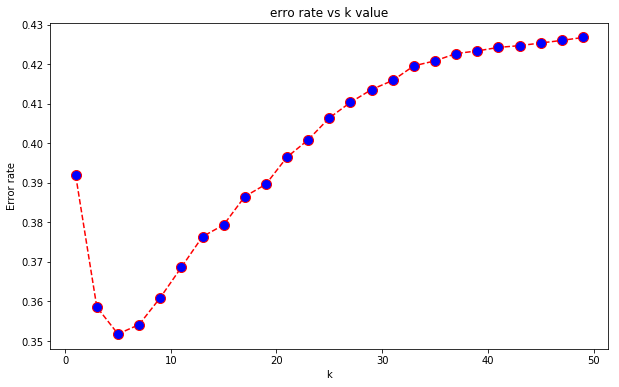

In [21]:
myList = list(range(0, 50))
optimal_k = find_optimal_k(X_train, y_train, myList)

__K-NN with optimal K__

In [22]:
Knn = KNeighborsClassifier(n_neighbors=optimal_k)
Knn.fit(X_train, y_train)
prediction = Knn.predict(X_test)

__Confusion matrix__

confusion matrix for test data

Text(33.0, 0.5, 'True Label')

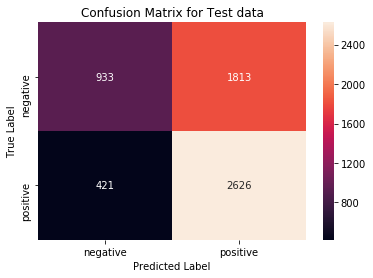

In [23]:
plt.figure()
con_mat = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_cm_test = pd.DataFrame(con_mat, index=class_label, columns = class_label)
sns.heatmap(df_cm_test, annot=True, fmt='d')
plt.title("Confusion Matrix for Test data")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### Classification Report

In [24]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

    Negative       0.69      0.34      0.46      2746
    Positive       0.59      0.86      0.70      3047

    accuracy                           0.61      5793
   macro avg       0.64      0.60      0.58      5793
weighted avg       0.64      0.61      0.58      5793



In [25]:
#### Accuray

In [26]:
print('Accuracy of KNN model with Bag of words is {0}%'.format(round(accuracy_score(y_test, prediction),3)*100))

Accuracy of KNN model with Bag of words is 61.4%



__You can try other algorithms by using cross-validation for model selection to select the best model !!__ 